# Recap of first order Trotter results
Recap notebook for first order Trotter results.

In [70]:
import numpy as np
import matplotlib.colors as mcolors  
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  
from iminuit import Minuit
from iminuit.cost import LeastSquares  

## My functions
All the functions I wrote to compute commutators numerically and other support functions.

In [71]:
def gen_Heisenberg_terms(N):
        XY = [] 
        XZ = []   
        YZ = [] 

        for i in range(N):
            for j in range(i+1, N):
                gate_id = f"g{i+1}{j+1}" 

                xx_term = ["X" if k == i or k == j else "I" for k in range(N)]
                yy_term = ["Y" if k == i or k == j else "I" for k in range(N)]
                zz_term = ["Z" if k == i or k == j else "I" for k in range(N)]

                XY.append((0.5, gate_id, "".join(xx_term)))
                XY.append((0.5, gate_id, "".join(yy_term)))

                XZ.append((0.5, gate_id, "".join(xx_term)))
                XZ.append((0.5, gate_id, "".join(zz_term)))

                YZ.append((0.5, gate_id, "".join(yy_term)))
                YZ.append((0.5, gate_id, "".join(zz_term)))

        return XY, XZ, YZ

In [72]:
pauli_mult_table = {
    ('I', 'I'): (1, 'I'),
    ('I', 'X'): (1, 'X'),
    ('I', 'Y'): (1, 'Y'),
    ('I', 'Z'): (1, 'Z'),
    ('X', 'I'): (1, 'X'),
    ('Y', 'I'): (1, 'Y'),
    ('Z', 'I'): (1, 'Z'),
    ('X', 'X'): (1, 'I'),
    ('Y', 'Y'): (1, 'I'),
    ('Z', 'Z'): (1, 'I'),
    ('Y', 'Z'): (+1j, 'X'),
    ('X', 'Y'): (+1j, 'Z'),
    ('Z', 'X'): (+1j, 'Y'),
    ('Y', 'X'): (-1j, 'Z'),
    ('Z', 'Y'): (-1j, 'X'),
    ('X', 'Z'): (-1j, 'Y'),
    ('0', 'I'): (0, '0'),
    ('0', 'X'): (0, '0'),
    ('0', 'Y'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('I', '0'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('Y', '0'): (0, '0'),
    ('Z', '0'): (0, '0')
}

In [73]:
def comm_pstr(pstr1, pstr2):
    """
    `comm_pstr(self, pstr1, pstr2)`
    pstr1, pstr2 (tuple): (numeric coefficient, couplings, individual Pauli string)

    comm_pstr function computes the commutator [pstr1, pstr2], keeping track of resulting numeric coefficient and coupling combination.
    return: (numeric coefficient, couplings, individual Pauli string) (tuple)
    """
    ps1 = pstr1[2] # e.g. "IXX"
    ps2 = pstr2[2] # e.g. "YIY"

    coeff = pstr1[0] * pstr2[0]
    psfinal = ""
    acomm_cnt = 0

    for i in range(len(ps1)):
        p1 = ps1[i]
        p2 = ps2[i]

        if p1 != p2 and p1 != 'I' and p2 != 'I': acomm_cnt += 1

        pair = pauli_mult_table[(p1, p2)]
        coeff = coeff * pair[0]
        psfinal += pair[1]

    if acomm_cnt % 2 == 0 or '0' in psfinal:
        return (0, "", '0'*len(ps1))
    
    return (2*coeff, f"({pstr1[1]})({pstr2[1]})", psfinal) # factor of 2 is introduced here

In [74]:
def comm_lincombo(psum1, psum2):
    """
    `comm_lincombo(self, psum1, psum2)`
    psum1, psum2 (list of tuples): [(numeric coefficient 1, couplings 1, individual Pauli string 1), ...]

    comm_lincombo computes the commutator of two sums of Pauli strings, keeping track of numerical coefficients and coupling powers.
    return: [(resulting numeric coefficient 1, resulting couplings 1, resulting individual Pauli string 1), ...] (list of tuples)
    """
    list_comm = []

    for elem1 in psum1:
        for elem2 in psum2:
            res = comm_pstr(elem1, elem2)
            if '0' not in res[2]: list_comm.append((res[0], res[1], res[2]))

    return list_comm

In [75]:
def group_by_pauli_string(comm, N):
    """
    `group_by_pauli_string(comm, N)`
    comm (list of tuples): [(numeric coefficient, couplings, Pauli string), ...]
    N (int)              : number of qubits

    group_by_pauli_string groups terms with the same Pauli string, and within those terms sums
    contributions with the same coupling coefficient

    return: dict {Pauli string: [[coefficient, coupling], ...], ...} 
    """

    def is_coeff_equal(str1, str2):
        pair1 = str1.split(")(")        
        pair2 = str2.split(")(")
        pair1 = [p.strip('(').strip(')').strip('g') for p in pair1]
        pair2 = [p.strip('(').strip(')').strip('g') for p in pair2]

        return sorted(pair1) == sorted(pair2)
        
    list_terms = {}
    for term in comm:
        if term[2] != "0"*N:
            if term[2] not in list_terms:
                list_terms[term[2]] = [[term[0], term[1]]]
            else:
                cnt_not = 0 
                for i, elem in enumerate(list_terms[term[2]]):
                    if is_coeff_equal(term[1], elem[1]):
                        list_terms[term[2]][i][0] += elem[0] # refactor coefficient
                    else:
                        cnt_not +=1 
                if cnt_not == len(list_terms[term[2]]): list_terms[term[2]].append([term[0], term[1]]) # TODO can it be changed to ([term[0], term[1])?

    return list_terms

In [76]:
values_N = np.arange(3,9)

XY3, XZ3, YZ3 = gen_Heisenberg_terms(3)
XY4, XZ4, YZ4 = gen_Heisenberg_terms(4)
XY5, XZ5, YZ5 = gen_Heisenberg_terms(5)
XY6, XZ6, YZ6 = gen_Heisenberg_terms(6)
XY7, XZ7, YZ7 = gen_Heisenberg_terms(7)
XY8, XZ8, YZ8 = gen_Heisenberg_terms(8)

XY3XZ3 = comm_lincombo(XY3, XZ3)
XY3YZ3 = comm_lincombo(XY3, YZ3)
XZ3YZ3 = comm_lincombo(XZ3, YZ3)

XY4XZ4 = comm_lincombo(XY4, XZ4)
XY4YZ4 = comm_lincombo(XY4, YZ4)
XZ4YZ4 = comm_lincombo(XZ4, YZ4)

XY5XZ5 = comm_lincombo(XY5, XZ5)
XY5YZ5 = comm_lincombo(XY5, YZ5)
XZ5YZ5 = comm_lincombo(XZ5, YZ5)

XY6XZ6 = comm_lincombo(XY6, XZ6)
XY6YZ6 = comm_lincombo(XY6, YZ6)
XZ6YZ6 = comm_lincombo(XZ6, YZ6)

XY7XZ7 = comm_lincombo(XY7, XZ7)
XY7YZ7 = comm_lincombo(XY7, YZ7)
XZ7YZ7 = comm_lincombo(XZ7, YZ7)

XY8XZ8 = comm_lincombo(XY8, XZ8)
XY8YZ8 = comm_lincombo(XY8, YZ8)
XZ8YZ8 = comm_lincombo(XZ8, YZ8)

terms_XY3XZ3 = group_by_pauli_string(XY3XZ3, N=3)
terms_XY3YZ3 = group_by_pauli_string(XY3YZ3, N=3)
terms_XZ3YZ3 = group_by_pauli_string(XZ3YZ3, N=3)

terms_XY4XZ4 = group_by_pauli_string(XY4XZ4, N=4)
terms_XY4YZ4 = group_by_pauli_string(XY4YZ4, N=4)
terms_XZ4YZ4 = group_by_pauli_string(XZ4YZ4, N=4)

terms_XY5XZ5 = group_by_pauli_string(XY5XZ5, N=5)
terms_XY5YZ5 = group_by_pauli_string(XY5YZ5, N=5)
terms_XZ5YZ5 = group_by_pauli_string(XZ5YZ5, N=5)

terms_XY6XZ6 = group_by_pauli_string(XY6XZ6, N=6)
terms_XY6YZ6 = group_by_pauli_string(XY6YZ6, N=6)
terms_XZ6YZ6 = group_by_pauli_string(XZ6YZ6, N=6)

terms_XY7XZ7 = group_by_pauli_string(XY7XZ7, N=7)
terms_XY7YZ7 = group_by_pauli_string(XY7YZ7, N=7)
terms_XZ7YZ7 = group_by_pauli_string(XZ7YZ7, N=7)

terms_XY8XZ8 = group_by_pauli_string(XY8XZ8, N=8)
terms_XY8YZ8 = group_by_pauli_string(XY8YZ8, N=8)
terms_XZ8YZ8 = group_by_pauli_string(XZ8YZ8, N=8)

In [77]:
def fixed_t_commsum_T1(terms, couplings, t): 
    """
    terms (list of dicts): [{"XYZ": [[-0.5j, "(g12)(g23)"], ...], ...}, {"XYZ": [[0.5j, "(g12)(g13)"], ...], ...}]
    couplings (dict): {"g12": 0.1, "g13": 0.2, ...}
    t (float): time length of simulation
    order (int): order of Trotter formula

    return: value of first order Trotter error for a given set of couplings and time  
    """

    def eval_couplings(coeff_str, coupl_dict):
        split_str = coeff_str.split(")(")
        split_str = [p.strip(')').strip('(') for p in split_str]

        prod = 1
        for term in split_str:
            prod *= coupl_dict[term]
            
        return prod
    
    err_vl = 0

    for term_dict in terms:
        for _, terms in term_dict.items():
            coeff = 0
            for term in terms:
                # if term[1] != '': coeff += float(str(term[0]).strip('j')) * eval_couplings(term[1], couplings)
                if term[1] != '': coeff += abs(term[0]) * eval_couplings(term[1], couplings)

            err_vl += abs(coeff)

    err_vl = 0.5 * err_vl * t ** 2

    return err_vl

In [78]:
mu = 1 * 1e2

def theta_nu(N, i, j, vl):
    return np.arccos(vl) * abs(i-j) / (N-1)

def fp_couplings(N, peakness): # fp = forward peaked
    """
    N (int): number of neutrinos
    peakness (float): in [-1,1)
    """
    if peakness < -1 or peakness >= 1: raise Exception(f"Value of peakness argument must be in [-1,1) interval, but {peakness} ins't.")
    coupl_dic = {}
    angle_dic = {}
    for i in range(N):
        for j in range(i+1, N):
            angle_dic[f"g{i+1}{j+1}"] = theta_nu(N, i, j, peakness)
            coupl_dic[f"g{i+1}{j+1}"] = mu * (1-np.cos(theta_nu(N, i, j, peakness))) / N

    return coupl_dic, angle_dic

def Theta(angles):
    return max(1 - np.cos(angle) for angle in angles.values())

## Models

In [83]:
def line(x, C, alpha):
    return C + alpha*x

def power_law(x, C, S):
    return C * x**S

def model_T1(x, gamma, K):
    return mu**2 * K * x**gamma / 8

def model_timenorm_m2(x, gammap, Kp):
    return mu**2 * Kp * x**(gammap-2) / 8

## Analysis
The aim of the analysis is to determine a bound for the first order Trotter error of my simulation by fitting the scaling law coefficients for the various parameters of the system of interest: a peaked neutrino beam.

I focus on fitting the $N$ dependance of the bound.

I propose the following model for the first order Trotter error:
$$
\mathcal{F}\left(dt,N,\{g_{ij}\}; K, \gamma\right)=\frac{1}{8}K\mu^2\Theta^2dt^2N^\gamma
$$
where $\Theta=\text{max}_{i,j}[1-\cos\theta_{ij}]$, $\theta_{ij}=\arccos(\upsilon)\frac{|i-j|}{N-1}$, with $\upsilon\in[-1,1)$; I call $\upsilon$ the _peakness_ parameter.

The data I fit is:
$$
    y(dt, N, \{g_{ij}\}) = dt^2 \mu^2 \{\dots\}
$$
where $dt^2\{\dots\}$ is computed by the `fixed_t_commsum1` function, and the fit function I use is `model_T1`

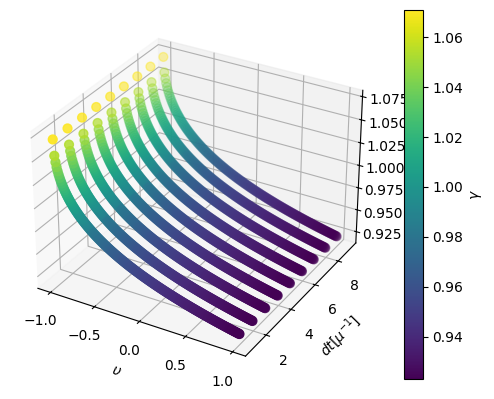

In [87]:
peakness_vls = np.arange(-100,100) * 1e-2
slopes_altfit = []
dt_list = np.arange(1,10) / mu

xs_altfit = []
ys_altfit = []
zs_altfit = []
Ks = []

for peak in peakness_vls:
    for dt in dt_list:
        err_vls_dt = []

        couplings3, angles3 = fp_couplings(3, peak)
        couplings4, angles4 = fp_couplings(4, peak)
        couplings5, angles5 = fp_couplings(5, peak)
        couplings6, angles6 = fp_couplings(6, peak)
        couplings7, angles7 = fp_couplings(7, peak)
        couplings8, angles8 = fp_couplings(8, peak)

        err_vls_dt.append(fixed_t_commsum_T1([terms_XY3XZ3, terms_XY3YZ3, terms_XZ3YZ3], couplings3, dt)/dt**2/Theta(angles3)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY4XZ4, terms_XY4YZ4, terms_XZ4YZ4], couplings4, dt)/dt**2/Theta(angles4)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY5XZ5, terms_XY5YZ5, terms_XZ5YZ5], couplings5, dt)/dt**2/Theta(angles5)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY6XZ6, terms_XY6YZ6, terms_XZ6YZ6], couplings6, dt)/dt**2/Theta(angles6)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY7XZ7, terms_XY7YZ7, terms_XZ7YZ7], couplings7, dt)/dt**2/Theta(angles7)**2)
        err_vls_dt.append(fixed_t_commsum_T1([terms_XY8XZ8, terms_XY8YZ8, terms_XZ8YZ8], couplings8, dt)/dt**2/Theta(angles8)**2)

        ls_obj = LeastSquares(values_N, err_vls_dt, 0.001, model_T1)
        m_obj = Minuit(ls_obj, gamma=1, K=1)
        m_obj.migrad()
        m_obj.hesse()

        slopes_altfit.append(m_obj.values[0])
        xs_altfit.append(peak)
        ys_altfit.append(dt*mu)
        zs_altfit.append(m_obj.values[0])   
        Ks.append(m_obj.values[1])      


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs_altfit, ys_altfit, zs_altfit, c=zs_altfit, cmap="viridis", s=40)

ax.set_xlabel(r"$\upsilon$")
ax.set_ylabel(r"$dt[\mu^{-1}]$")
ax.set_zlabel(r"$\gamma$")
fig.colorbar(scatter, ax=ax, label=r"$\gamma$")

plt.show()

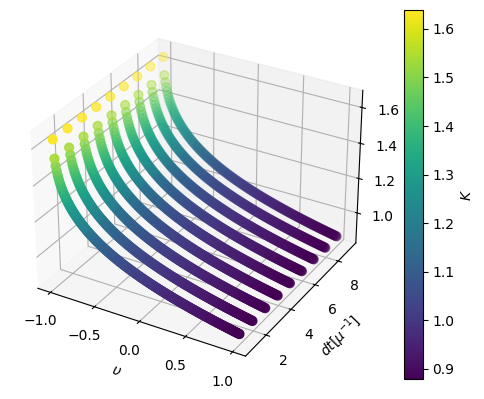

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs_altfit, ys_altfit, Ks, c=Ks, cmap="viridis", s=40)

ax.set_xlabel(r"$\upsilon$")
ax.set_ylabel(r"$dt[\mu^{-1}]$")
ax.set_zlabel(r"$\gamma$")
fig.colorbar(scatter, ax=ax, label=r"$K$")

plt.show()